# MIDAS Code Example


This Jupyter notebook is a quick interactive example of how to use MIDAS in practice. To this end, I will quickly reproduce the method by which we attained estimated variance of imputed values on the [Adult Census dataset](https://archive.ics.uci.edu/ml/datasets/adult).

Code right now is very hot. If you have any problems getting this demo running, it may just be I've respecified default parameters.

For now, setup must be done manually. Later versions will include pip support. Copy both midas.py and adult_data.csv into your Jupyter Notebooks directory. This is so they can be read into memory. The first thing we will do is manage imports, and import the data we will be using.  

In [4]:
from midas import Midas
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# import csv2utf8
# already created utf8 files

data_0 = pd.read_csv('train_midas-utf8.csv').drop(['Unnamed: 0'], axis=1)
print(data_0.head())

   주야 요일  사망자수  사상자수  중상자수  경상자수  부상신고자수 발생지시도 발생지시군구 사고유형_대분류 사고유형_중분류  \
0  야간  금     1     1     0     0       0    경기    성남시     차대사람      횡단중   
1  야간  금     1     4     2     1       0    전남    곡성군      차대차       추돌   
2  야간  금     1     1     0     0       0    충남    서산시     차대사람    차도통행중   
3  야간  금     1     1     0     0       0    대구     서구      차대차     측면충돌   
4  주간  금     1     2     1     0       0    서울   영등포구      차대차     측면충돌   

          법규위반 도로형태_대분류   도로형태 당사자종별_1당_대분류 당사자종별_2당_대분류  
0  안전운전 의무 불이행      단일로  기타단일로          승용차          보행자  
1  안전운전 의무 불이행      단일로  기타단일로          승용차          승용차  
2  안전운전 의무 불이행      단일로  기타단일로          승용차          보행자  
3  안전운전 의무 불이행      교차로  교차로부근          승용차          이륜차  
4       중앙선 침범      단일로    교량위          이륜차          화물차  


Next, we will generate some missingness. Very few columns in the actual data contain missing values, so we want to change this. For the variance tests, we spiked in 100 values to test against. For this example, let's make this number a little larger - 5000 values in each column. We will then replace the sampled indices with np.nan...our missing value. While it is possible to sample 5000 values directly, we often used masks as they allow us to return later and inspect the error. While this notebook won't be reproducing that process, feel free to adapt the code examples. We also save one of the removed values for the end.

In [5]:
np.random.seed(441)

# missingness를 만드는 것

def spike_in_generation(data):
    spike_in = pd.DataFrame(np.zeros_like(data), columns= data.columns)
    for column in data.columns:
        subset = np.random.choice(data[column].index[data[column].notnull()],
                                     5000, replace= False)
        spike_in.loc[subset, column] = 1
    return spike_in

spike_in = spike_in_generation(data_0)
original_value = data_0.loc[4, '사상자수']
data_0[spike_in == 1] = np.nan

The next task is to code the categorical variables. This is done by subsetting them out to a new dataframe, and converting them to One-Hot. We need to ensure that missing values aren't converted to zeroes yet, so we generate a temporary index to mark the location of missing entries. Finally, the encoded categorical columns are appended to a list already containing data_0 - the continuous variables. 

The utility of columns_list may not be apparent now, but it simplifies things immensely when it comes to building the MIDAS instance. If your data contains a lot of categorical data that needs conversion to One-Hot, consider implementing something similar.

In [6]:
categorical = ['주야','요일','발생지시도','발생지시군구', '사고유형_대분류','사고유형_중분류','법규위반','도로형태_대분류','도로형태','당사자종별_1당_대분류','당사자종별_2당_대분류']
data_0.columns.str.strip() # 왼, 오른 쪽의 공백 제거
data_1 = data_0[categorical]
data_0.drop(categorical, axis= 1, inplace= True)

constructor_list = [data_0]
columns_list = []

# column 서치 하면서, null인 놈은 체크하고, 일단 전부 dummy 변환 해 준 다음에
# null 인 놈은 나중에 np.nan으로 넣어주기.
# columns_list 에, dummy variable names들 저장

for column in data_1.columns:
    na_temp = data_1[column].isnull()
    temp = pd.get_dummies(data_1[column]) # pd.get_dummies 는 categorical 변수를 dummy 변수로 바꿔줌
    #print(temp.loc[0:15])
    #temp[na_temp] = np.nan
    #print(temp.loc[0:15])
    constructor_list.append(temp)
    columns_list.append(list(temp.columns.values))
    #print(columns_list)


Next, we concat the dataset back into one dataframe, and apply a minmax scaler. Minmax maps the range of all values to between 0 and 1 - useful for keeping the gradients flowing through the neural network small. Smaller numbers means weight updates will have gradual change, not destructive oscillation. In some cases, having the minimum value equal to 0 does have some drawbacks, though. If your low-end values are giving you strange results, consider trying a different scaling scheme.

We used the minmax scaler on the entire dataset for convenience. Minmax won't affect OneHot variables, but other scalers might. Again, we marked the locations of the np.nan values, and were sure to replace them once we'd scaled the columns. Numpy, SkLearn and Tensorflow don't share R's 'na.rm' functionality. Instead, we have to be sure to pass in numeric values or else we'll have errors returned.

In [ ]:
data_0 = pd.concat(constructor_list, axis=1)
#print("1")
print(data_0.head())
#print(type(data_0))

# minmax scaler는 na에 대한 처리를 못함.
# 그래서, null인 부분은 각각의 median으로 replace한 다음에 0~1로 transform하고, 다시 na로 바꿔줌.

scaler = MinMaxScaler()
na_loc = data_0.isnull()

# 아래 코드, fillna 함수가 동작을 안하는데 이유를 모르겠음.
data_0.fillna(data_0.median, inplace = True)
print(data_0.head())

data_0 = pd.DataFrame(scaler.fit_transform(data_0), columns= data_0.columns)
data_0[na_loc] = np.nan
print(data_0.head())

Finally, with the data prepared, we can use MIDAS to impute the missing vlaues. The first thing we will do is instantiate MIDAS. For this test, we will build a small 2 layer, 128 units per layer, network for demonstration. The layer_structure argument defaults to mirroring the input layer structure on the output. All the hyperparameters are specified in the instantiation, and all the data is passed into the .build_model() method. As the categories we are using are mutually exclusive, we must pass these column names into the softmax_columns argument. This ensures we have error accurately measured for each category, and the loss is appropriately weighted.

In general, bigger models are better. The 'magic' of stochastic regularisation means it's generally better to have excess capacity as opposed to not enough. Feel free to experiment with larger and smaller models, but remember...bigger models can take much longer to train! Moving the layers up to 512 or 1024 leads to a noticeable increase in performance, although other hyperparameters (such as  learn_rate) need to be tuned in parallel.

In [79]:
imputer = Midas(layer_structure= [128], vae_layer= False, seed= 42)
imputer.build_model(data_0, softmax_columns= columns_list)

Size index: [6, 8, 16, 7, 14, 6, 5, 2, 41]


/Users/eunseok/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Computation graph constructed



There are a number of additional arguments that can be passed to both the instantiation and most methods. To check what they are and recommended settings, consult the [list of MIDAS functions](https://github.com/Oracen/MIDAS/blob/master/midas_functions.md). Alternatively, just use the ?? command on any method to display the help text. Using the help command on the class itself will bring up the entire source code, so if you're not used to coding in Python, the commands you're looking for are found under "init". 

In [80]:
??Midas.generate_samples()

In [81]:
??Midas

First, we want to make sure our model is building an accurate representation of the data. The first method we should call is .overimpute(). This method removes a set proportion of known values, and allows us to explore the evolution of the model's output. It is a way of estimating the ideal model complexity which will give us the most accurate imputations - the values become our out-of-sample data. We do not want to do this during the actual run, though. Not only does a train-test split setup overestimate ideal model complexity in autoencoders, but it denies the model anywhere between 10% and 30% of existing data. At higher levels of missingness, this additional data could be crucial.

In general, we want to see both cost and out-of-sample error constantly decreasing. In practice, too much capacity and too much training may cause error to rise again. This is called overtraining, and it is to be avoided. If clear overtraining appears while running .overimpute(), ensure that the 'training_epochs' argument of .train_model() is set to end training before this point.


Model initialised

Epoch: 0 , loss: 7.222314281982332
Individual RMSE on spike-in: 0.15036773279941418
Aggregated RMSE on spike-in: 0.1328242821312184
Individual error on softmax spike-in: 0.37586101503249975
Aggregated error on softmax spike-in: 0.3539626835820352


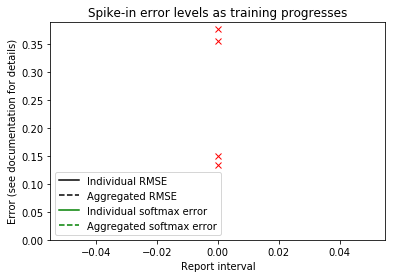

Epoch: 1 , loss: 3.8383815820142138
Individual RMSE on spike-in: 0.1404247906318892
Aggregated RMSE on spike-in: 0.1312435581811743
Individual error on softmax spike-in: 0.37322661253798645
Aggregated error on softmax spike-in: 0.3368442311537183


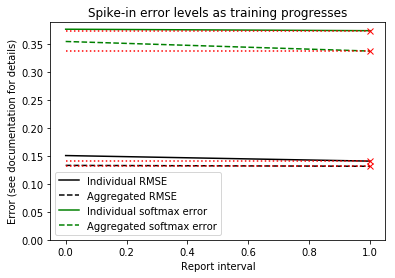

Epoch: 2 , loss: 2.922212590474445
Individual RMSE on spike-in: 0.13755347136129129
Aggregated RMSE on spike-in: 0.13046394743772025
Individual error on softmax spike-in: 0.3767230401199705
Aggregated error on softmax spike-in: 0.33506570591032947


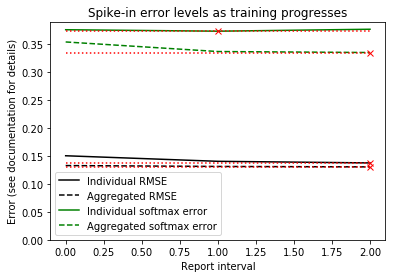

Epoch: 3 , loss: 2.565232826365087
Individual RMSE on spike-in: 0.1366242871353062
Aggregated RMSE on spike-in: 0.13069281266400518
Individual error on softmax spike-in: 0.37626006232747256
Aggregated error on softmax spike-in: 0.33299728734572315


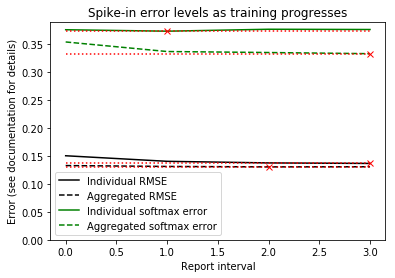

Epoch: 4 , loss: 2.398339018479556
Individual RMSE on spike-in: 0.13591194415217928
Aggregated RMSE on spike-in: 0.1305301937823126
Individual error on softmax spike-in: 0.3751206939784829
Aggregated error on softmax spike-in: 0.33270942835371087


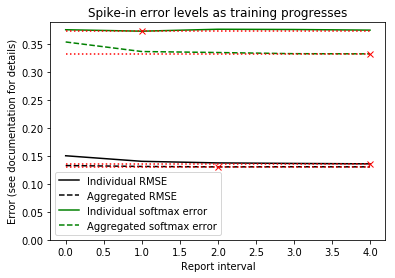

Epoch: 5 , loss: 2.2880195144119613
Individual RMSE on spike-in: 0.13645741240355844
Aggregated RMSE on spike-in: 0.13118453009660724
Individual error on softmax spike-in: 0.3759679702356175
Aggregated error on softmax spike-in: 0.33344224254439764


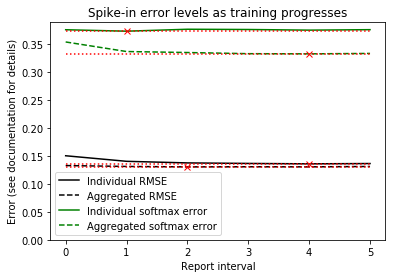

Epoch: 6 , loss: 2.2270451900335626
Individual RMSE on spike-in: 0.13544191071737843
Aggregated RMSE on spike-in: 0.13022225947358076
Individual error on softmax spike-in: 0.37642589463138965
Aggregated error on softmax spike-in: 0.33328871762865575


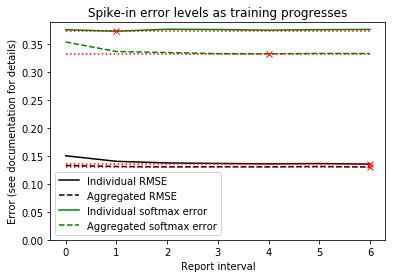

Epoch: 7 , loss: 2.1816830304432977
Individual RMSE on spike-in: 0.13565580971316976
Aggregated RMSE on spike-in: 0.13062337293896167
Individual error on softmax spike-in: 0.37520395333602546
Aggregated error on softmax spike-in: 0.33007290888539337


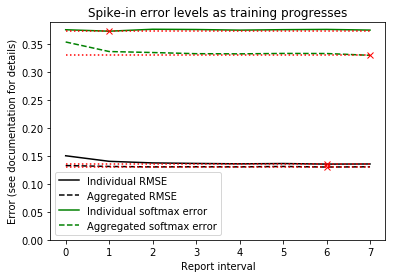

Epoch: 8 , loss: 2.166861162058335
Individual RMSE on spike-in: 0.13567753169720115
Aggregated RMSE on spike-in: 0.13040963044959267
Individual error on softmax spike-in: 0.37408248773323755
Aggregated error on softmax spike-in: 0.3317958640136616


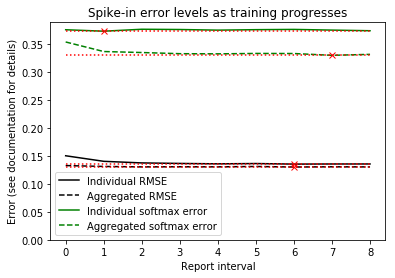

Epoch: 9 , loss: 2.1275605432601306
Individual RMSE on spike-in: 0.1352310443177663
Aggregated RMSE on spike-in: 0.12994488126943285
Individual error on softmax spike-in: 0.37317816894338407
Aggregated error on softmax spike-in: 0.3294993684590378


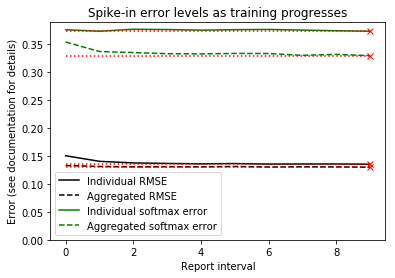

Epoch: 10 , loss: 2.132398361225428
Individual RMSE on spike-in: 0.1347632767633205
Aggregated RMSE on spike-in: 0.12980775502842312
Individual error on softmax spike-in: 0.3742685689945681
Aggregated error on softmax spike-in: 0.32996021447901447


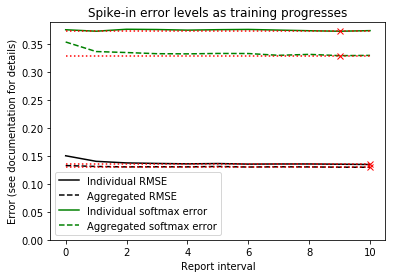

Overimputation complete. Adjust complexity as needed.


In [82]:
imputer.overimpute(training_epochs= 10, report_ival= 1,
                   report_samples= 5, plot_all= False)

5 epochs seemed to be a reasonable number. In reality, had we run the algorithm longer, we probably would have attained better results. In fact, in practice we want to run overimputation for as long as time will allow, to ensure we are getting the most accurate possible results. Still, 5 epochs will will serve for the purposes of this demo.

We run the .train_model() method, with printouts every epoch to ensure training is progressing as expected. With longer training times, increasing the interval between loss reports is a good way to remove clutter from your output.

In [83]:
imputer.train_model(training_epochs= 5, verbosity_ival= 1)

Model initialised

Epoch: 0 , loss: 7.234585653595031
Epoch: 1 , loss: 3.8797425939011854
Epoch: 2 , loss: 2.94306984633637
Epoch: 3 , loss: 2.561249842025037
Epoch: 4 , loss: 2.379799068442803
Training complete. Saving file...
Model saved in file: tmp/MIDAS


Now the model is trained, we can use the saved model to generate as many imputations as we need. We generate 20 samples, which will be saved to the .output_list attribute. We then recall the value we saved right at the very start of the demo, and from each dataset extract the value for the same observation as well as its mean. Of course, now that the model is saved, we don't need to retrain the model should we return to this result.

In [85]:
imputer.batch_generate_samples(m= 5)

print("Original value:", original_value)
imputed_vals = []
for dataset in imputer.output_list:
    temp_pd = pd.DataFrame(scaler.inverse_transform(dataset),
                                     columns= dataset.columns)
    print("%%%%%")
    print(temp_pd.head())
    print("%%%%%")
    imputed_vals.append(temp_pd.loc[4, 'hours_per_week'])
print("Imputed values:")
print(imputed_vals)
print("Imputation mean:", np.mean(imputed_vals))
print("Standard deviation of the imputation mean:", np.std(imputed_vals))


# 더미 변수를 역변환 하는 함수랑 float를 반올림 하는 함수 필요

INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.
Original value: 40
%%%%%
       age    fnlwgt  education_num  capital_gain  capital_loss  \
0  39.0000   77516.0           13.0        2174.0      0.000000   
1  49.0968   83311.0           13.0           0.0     16.886283   
2  38.0000  215646.0            9.0           0.0      0.000000   
3  53.0000  234721.0            7.0           0.0      0.000000   
4  28.0000  338409.0           13.0           0.0      0.000000   

   hours_per_week  Federal-gov  Local-gov  Never-worked   Private     ...      \
0       40.000000     0.000000   0.000000      0.000000  0.000000     ...       
1       13.000000     0.000000   0.000000      0.000000  0.000000     ...       
2       40.000000     0.000000   0.000000      0.000000  1.000000     ...       
3       40.000000     0.000000   0.000000      0.000000  1.000000     ...       
4       33.883784     0.009851   0.023148      0.000965  0.947147     ...       

   Portugal  Puer

Code-wise, that's it! You may notice the imputation mean is not perfectly accurate, with a low variance. This is a known limitation of variational inference methods, and we're currently working on implementing solutions that will improve the match between true and estimated data. In general; MIDAS currently underestimates the marginal posterior density. Unfortunately, this flows out of the maths of KL(Q||P) underlying Gal's Bayesian interpretation of dropout. That being the case, methods for improving variational estimates within deep learning are constantly improving.

This short demonstration has illustrated the main steps in using MIDAS. I hope it helps you with your own missing data challenges.